# Kaggle Competition Notebook

- Author: Hasnain Yaqoob
- LinkedIn: https://www.linkedin.com/in/hasnain-yaqoob/
- GitHub: https://github.com/hasnainyaqoob


# Survival Rate Prediction on Titanic Dataset using Neural Networks in TensorFlow

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [16]:
# load the data 
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/gender_submission.csv')

In [17]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
df_train.shape

(891, 12)

In [19]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Let's explore the data

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [22]:
((df_train.isnull().sum() / df_train.shape[0]) * 100).sort_values(ascending=False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

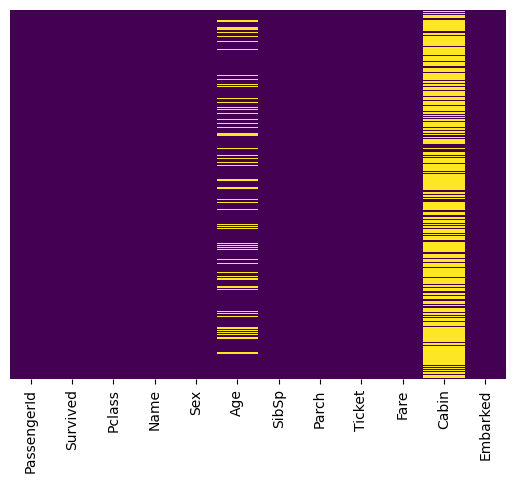

In [23]:
# lets see how many missing values we have in the data by creating a plot

sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

------------
# Dealing with missing values

In [24]:
df = df_train
# let's split the  columns with missing values into list
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
print(missing_data_cols)
# let's split the columns with missing values into categorical and numeric columns
categorical_cols = [col for col in df.columns if df_train[col].dtypes == 'O']
bool_cols = []
numeric_cols = [col for col in df.columns if df_train[col].dtypes == 'float64']

['Age', 'Cabin', 'Embarked']


In [25]:
df.shape

(891, 12)

In [9]:
# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    # print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [10]:
# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
        pass
    else:
        pass

Missing Values Age : 19.87%
MAE = 9.24798811188811 

R2 = 0.2685213647413145 

Missing Values Cabin : 77.1%
The feature 'Cabin' has been imputed with 24.39 accuracy

Missing Values Embarked : 0.22%
The feature 'Embarked' has been imputed with 87.64 accuracy



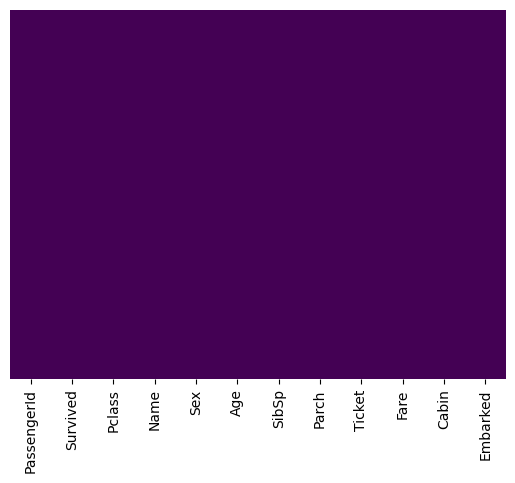

In [63]:
# plot missing values 

sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()


In [64]:
# lets encode the categorical columns 
le_list = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_list[col] = le

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,108,1,22.0,1,0,523,7.2500,139,2
1,2,1,1,190,0,38.0,1,0,596,71.2833,81,0
2,3,1,3,353,0,26.0,0,0,669,7.9250,145,2
3,4,1,1,272,0,35.0,1,0,49,53.1000,55,2
4,5,0,3,15,1,35.0,0,0,472,8.0500,115,2


In [65]:
# lets normalize the numeric columns 
scaler = StandardScaler()

for col in numeric_cols:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [66]:
# Split the data into X and y
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Let's Create the Neural Network for Binary Classification.

In [78]:
# let's build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


Epoch 1/100
23/23 [==============================] - 3s 34ms/step - loss: 18.5001 - accuracy: 0.5239 - val_loss: 9.5012 - val_accuracy: 0.5307
Epoch 2/100
23/23 [==============================] - 0s 15ms/step - loss: 4.4499 - accuracy: 0.5885 - val_loss: 3.6549 - val_accuracy: 0.6089
Epoch 3/100
23/23 [==============================] - 0s 18ms/step - loss: 2.5758 - accuracy: 0.6039 - val_loss: 2.3908 - val_accuracy: 0.5363
Epoch 4/100
23/23 [==============================] - 0s 17ms/step - loss: 1.7405 - accuracy: 0.6011 - val_loss: 1.7421 - val_accuracy: 0.6034
Epoch 5/100
23/23 [==============================] - 1s 24ms/step - loss: 1.6030 - accuracy: 0.6278 - val_loss: 1.5764 - val_accuracy: 0.6145
Epoch 6/100
23/23 [==============================] - 1s 23ms/step - loss: 1.3256 - accuracy: 0.6110 - val_loss: 1.5666 - val_accuracy: 0.6425
Epoch 7/100
23/23 [==============================] - 1s 28ms/step - loss: 1.2580 - accuracy: 0.6404 - val_loss: 1.5729 - val_accuracy: 0.5419
Epoch

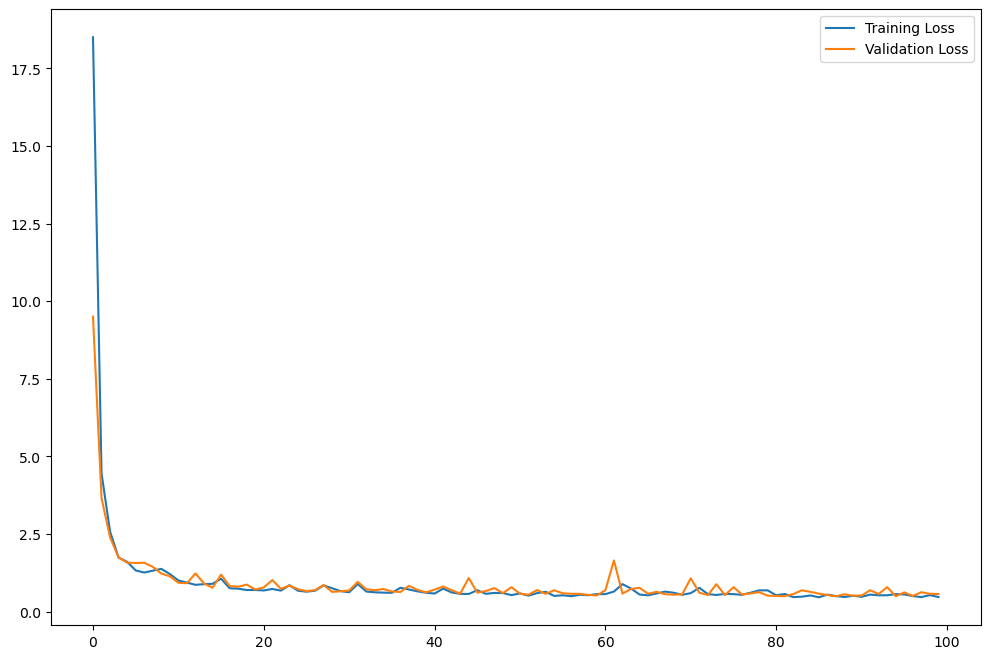

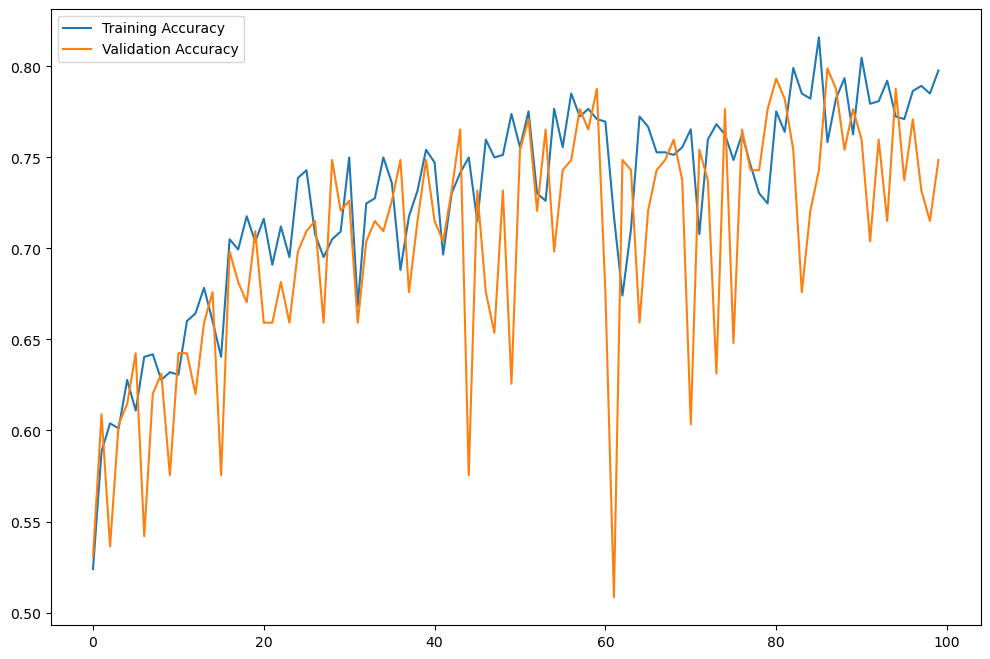

In [79]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test Acuracy:', accuracy)
 
 # plot the training and testing loss and accuracy at each epoch
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.legend()
plt.show()
